#  Concentration de CO2 dans l'atmosphère depuis 1958

Ce document analyse l'évolution de la concentration de CO2 dans l'atmosphère depuis 1958 à aujourd'hui, en se basant sur les données disponibles sur le site du [Scripps CO2 Program](https://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record.html). Les données utilisées proviennent de relevés mensuels effectués à la station de Mauna Loa.

Pour plus d'informations, vous pouvez consulter :

_C. D. Keeling, S. C. Piper, R. B. Bacastow, M. Wahlen, T. P. Whorf, M. Heimann, and H. A. Meijer, Exchanges of atmospheric CO2 and 13CO2 with the terrestrial biosphere and oceans from 1978 to 2000. I. Global aspects, SIO Reference Series, No. 01-06, Scripps Institution of Oceanography, San Diego, 88 pages, 2001._


In [75]:
 %matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import os
import urllib
import numpy as np
from scipy.optimize import curve_fit
import math

Le fichier `csv` contenant les données est disponible à l'adresse suivante :

In [76]:
data_url = "https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/monthly/monthly_in_situ_co2_mlo.csv"

 Nous conservons les données dans un fichier local, afin que la conservation du fichier sur lequel nous effectuons notre analyse soit robuste aux défaillances du site Sentiweb. À cette fin également, nous ne retéléchargeons pas automatiquement une nouvelle version à chaque exécution, mais seulement si le fichier local est manquant.

In [77]:
if not os.path.exists("monthly_in_situ_co2_mlo.csv"):
    urllib.request.urlretrieve(data_url, "monthly_in_situ_co2_mlo.csv")

Comme expliqué dans le fichier `csv`, les données sont organisées en 10 colonnes :

Numéro de colonne | Libellé | Contenu | Unité ou format (si applicable)
:---------------- | :------ | :------ | :--------------------
1 | Yr | Année du relevé |
2 | Mn | Mois du relevé |
3 | Date | Date du relevé | format Excel
4 | Date | Date du relevé | date décimale
5 | CO2 | Relevé de la concentration en C02 (2012 SIO manometric mole fraction scale), ajusté aux 24h du 15ème de chaque mois | ppm
6 | seasonally adjusted | Relevés orignaux (CO2) ajustés pour retirer le cycle saisonnier régulier | ppm
7 | fit | Relevés originaux (C02) lissés | ppm
8 | seasonally adjusted fit | Relevés lissés ajustés saisonalement | ppm
9 | CO2 filled | Relevés originaux (CO2) complétés par les résultats lissés (fit) | ppm
10 | seasonally adjusted fit filled | Relevés ajustés saisonalement (seasonally adjusted) complétés par les résultats lissés et ajustés (seasonally adjusted fit) | ppm

Les 55 premières lignes contiennent les explications ci-dessus, donc nous ne les traiterons pas avec les autres données. Nous renommons également les colonnes pour plus de concision et de clarté.

In [78]:
raw_data = pd.read_csv("monthly_in_situ_co2_mlo.csv", skiprows=56)
c_names = raw_data.columns.values
raw_data = raw_data.rename(columns = {c_names[0]:"Yr", c_names[1]:"Mn", c_names[2]:"EDate", c_names[3]:"DDate", c_names[4]:"C02", c_names[5]:"SA", c_names[6]:"Fit", c_names[7]:"SAFit", c_names[8]:"Filled", c_names[9]:"SAFitFilled"})
raw_data

Yr  Mn  EDate      DDate     C02      SA     Fit   SAFit  Filled  \
0    1958   1  21200  1958.0411  -99.99  -99.99  -99.99  -99.99  -99.99   
1    1958   2  21231  1958.1260  -99.99  -99.99  -99.99  -99.99  -99.99   
2    1958   3  21259  1958.2027  315.71  314.44  316.20  314.91  315.71   
3    1958   4  21290  1958.2877  317.45  315.16  317.30  314.99  317.45   
4    1958   5  21320  1958.3699  317.51  314.70  317.88  315.07  317.51   
5    1958   6  21351  1958.4548  -99.99  -99.99  317.26  315.15  317.26   
6    1958   7  21381  1958.5370  315.87  315.20  315.86  315.22  315.87   
7    1958   8  21412  1958.6219  314.93  316.21  313.98  315.29  314.93   
8    1958   9  21443  1958.7068  313.21  316.10  312.45  315.36  313.21   
9    1958  10  21473  1958.7890  -99.99  -99.99  312.43  315.41  312.43   
10   1958  11  21504  1958.8740  313.33  315.21  313.61  315.46  313.33   
11   1958  12  21534  1958.9562  314.67  315.43  314.77  315.52  314.67   
12   1959   1  21565  1959.0411  315.58  315.52  315.64  315.58  315.58   
13   1959   2  21596  1959.1260  316.49  315.84  316.29  315.64  316.49   
14   1959   3  21624  1959.2027  316.65  315.37  316.99  315.70  316.65   
15   1959   4  21655  1959.2877  317.72  315.42  318.09  315.77  317.72   
16   1959   5  21685  1959.3699  318.29  315.48  318.67  315.85  318.29   
17   1959   6  21716  1959.4548  318.15  316.01  318.06  315.94  318.15   
18   1959   7  21746  1959.5370  316.54  315.87  316.67  316.03  316.54   
19   1959   8  21777  1959.6219  314.80  316.08  314.81  316.13  314.80   
20   1959   9  21808  1959.7068  313.84  316.74  313.30  316.22  313.84   
21   1959  10  21838  1959.7890  313.33  316.33  313.32  316.31  313.33   
22   1959  11  21869  1959.8740  314.81  316.69  314.54  316.40  314.81   
23   1959  12  21899  1959.9562  315.58  316.35  315.73  316.48  315.58   
24   1960   1  21930  1960.0410  316.43  316.37  316.63  316.56  316.43   
25   1960   2  21961  1960.1257  316.98  316.33  317.30  316.64  316.98   
26   1960   3  21990  1960.2049  317.58  316.27  318.04  316.72  317.58   
27   1960   4  22021  1960.2896  319.03  316.70  319.14  316.80  319.03   
28   1960   5  22051  1960.3716  320.03  317.21  319.69  316.87  320.03   
29   1960   6  22082  1960.4563  319.59  317.46  319.03  316.93  319.59   
..    ...  ..    ...        ...     ...     ...     ...     ...     ...   
750  2020   7  44027  2020.5383  414.42  413.64  414.77  414.03  414.42   
751  2020   8  44058  2020.6230  412.52  414.10  412.61  414.23  412.52   
752  2020   9  44089  2020.7077  411.18  414.69  410.90  414.43  411.18   
753  2020  10  44119  2020.7896  411.12  414.73  411.02  414.62  411.12   
754  2020  11  44150  2020.8743  412.88  415.15  412.57  414.81  412.88   
755  2020  12  44180  2020.9563  413.89  414.81  414.08  414.99  413.89   
756  2021   1  44211  2021.0411  415.15  415.08  415.25  415.16  415.15   
757  2021   2  44242  2021.1260  416.47  415.69  416.13  415.34  416.47   
758  2021   3  44270  2021.2027  417.16  415.62  417.06  415.50  417.16   
759  2021   4  44301  2021.2877  418.24  415.46  418.47  415.67  418.24   
760  2021   5  44331  2021.3699  418.95  415.55  419.24  415.84  418.95   
761  2021   6  44362  2021.4548  418.70  416.12  418.58  416.02  418.70   
762  2021   7  44392  2021.5370  416.65  415.84  416.97  416.20  416.65   
763  2021   8  44423  2021.6219  414.34  415.89  414.79  416.39  414.34   
764  2021   9  44454  2021.7068  412.90  416.41  413.05  416.58  412.90   
765  2021  10  44484  2021.7890  413.55  417.17  413.15  416.76  413.55   
766  2021  11  44515  2021.8740  414.82  417.09  414.70  416.94  414.82   
767  2021  12  44545  2021.9562  416.43  417.36  416.20  417.11  416.43   
768  2022   1  44576  2022.0411  418.01  417.94  417.35  417.26  418.01   
769  2022   2  44607  2022.1260  418.99  418.20  418.20  417.40  418.99   
770  2022   3  44635  2022.2027  418.45  416.90  419.08  417.51  418.45   
771  2022   4  44666  2022.2877 

On notera que les valeurs manquantes sont notées `-99.99` dans le fichier, et que même les colonnes `Filled` contiennent ces valeurs manquantes pour les données de janvier et février 1958 et les mois les plus récents :

In [79]:
missing_data = raw_data.iloc[lambda df: [(raw_data.at[row,'SAFitFilled'] == -99.99) for row in df.index]]
missing_data

Yr  Mn  EDate      DDate    C02     SA    Fit  SAFit  Filled  \
0    1958   1  21200  1958.0411 -99.99 -99.99 -99.99 -99.99  -99.99   
1    1958   2  21231  1958.1260 -99.99 -99.99 -99.99 -99.99  -99.99   
775  2022   8  44788  2022.6219 -99.99 -99.99 -99.99 -99.99  -99.99   
776  2022   9  44819  2022.7068 -99.99 -99.99 -99.99 -99.99  -99.99   
777  2022  10  44849  2022.7890 -99.99 -99.99 -99.99 -99.99  -99.99   
778  2022  11  44880  2022.8740 -99.99 -99.99 -99.99 -99.99  -99.99   
779  2022  12  44910  2022.9562 -99.99 -99.99 -99.99 -99.99  -99.99   

     SAFitFilled  
0         -99.99  
1         -99.99  
775       -99.99  
776       -99.99  
777       -99.99  
778       -99.99  
779       -99.99

This missing data is removed from the dataframe.

In [80]:
data = raw_data.drop(missing_data.index).copy()
data

Yr  Mn  EDate      DDate     C02      SA     Fit   SAFit  Filled  \
2    1958   3  21259  1958.2027  315.71  314.44  316.20  314.91  315.71   
3    1958   4  21290  1958.2877  317.45  315.16  317.30  314.99  317.45   
4    1958   5  21320  1958.3699  317.51  314.70  317.88  315.07  317.51   
5    1958   6  21351  1958.4548  -99.99  -99.99  317.26  315.15  317.26   
6    1958   7  21381  1958.5370  315.87  315.20  315.86  315.22  315.87   
7    1958   8  21412  1958.6219  314.93  316.21  313.98  315.29  314.93   
8    1958   9  21443  1958.7068  313.21  316.10  312.45  315.36  313.21   
9    1958  10  21473  1958.7890  -99.99  -99.99  312.43  315.41  312.43   
10   1958  11  21504  1958.8740  313.33  315.21  313.61  315.46  313.33   
11   1958  12  21534  1958.9562  314.67  315.43  314.77  315.52  314.67   
12   1959   1  21565  1959.0411  315.58  315.52  315.64  315.58  315.58   
13   1959   2  21596  1959.1260  316.49  315.84  316.29  315.64  316.49   
14   1959   3  21624  1959.2027  316.65  315.37  316.99  315.70  316.65   
15   1959   4  21655  1959.2877  317.72  315.42  318.09  315.77  317.72   
16   1959   5  21685  1959.3699  318.29  315.48  318.67  315.85  318.29   
17   1959   6  21716  1959.4548  318.15  316.01  318.06  315.94  318.15   
18   1959   7  21746  1959.5370  316.54  315.87  316.67  316.03  316.54   
19   1959   8  21777  1959.6219  314.80  316.08  314.81  316.13  314.80   
20   1959   9  21808  1959.7068  313.84  316.74  313.30  316.22  313.84   
21   1959  10  21838  1959.7890  313.33  316.33  313.32  316.31  313.33   
22   1959  11  21869  1959.8740  314.81  316.69  314.54  316.40  314.81   
23   1959  12  21899  1959.9562  315.58  316.35  315.73  316.48  315.58   
24   1960   1  21930  1960.0410  316.43  316.37  316.63  316.56  316.43   
25   1960   2  21961  1960.1257  316.98  316.33  317.30  316.64  316.98   
26   1960   3  21990  1960.2049  317.58  316.27  318.04  316.72  317.58   
27   1960   4  22021  1960.2896  319.03  316.70  319.14  316.80  319.03   
28   1960   5  22051  1960.3716  320.03  317.21  319.69  316.87  320.03   
29   1960   6  22082  1960.4563  319.59  317.46  319.03  316.93  319.59   
30   1960   7  22112  1960.5383  318.18  317.53  317.60  316.98  318.18   
31   1960   8  22143  1960.6230  315.90  317.22  315.67  317.02  315.90   
..    ...  ..    ...        ...     ...     ...     ...     ...     ...   
745  2020   2  43876  2020.1257  414.05  413.27  413.83  413.04  414.05   
746  2020   3  43905  2020.2049  414.45  412.88  414.82  413.23  414.45   
747  2020   4  43936  2020.2896  416.11  413.31  416.25  413.43  416.11   
748  2020   5  43966  2020.3716  417.15  413.76  417.02  413.63  417.15   
749  2020   6  43997  2020.4563  416.29  413.74  416.36  413.83  416.29   
750  2020   7  44027  2020.5383  414.42  413.64  414.77  414.03  414.42   
751  2020   8  44058  2020.6230  412.52  414.10  412.61  414.23  412.52   
752  2020   9  44089  2020.7077  411.18  414.69  410.90  414.43  411.18   
753  2020  10  44119  2020.7896  411.12  414.73  411.02  414.62  411.12   
754  2020  11  44150  2020.8743  412.88  415.15  412.57  414.81  412.88   
755  2020  12  44180  2020.9563  413.89  414.81  414.08  414.99  413.89   
756  2021   1  44211  2021.0411  415.15  415.08  415.25  415.16  415.15   
757  2021   2  44242  2021.1260  416.47  415.69  416.13  415.34  416.47   
758  2021   3  44270  2021.2027  417.16  415.62  417.06  415.50  417.16   
759  2021   4  44301  2021.2877  418.24  415.46  418.47  415.67  418.24   
760  2021   5  44331  2021.3699  418.95  415.55  419.24  415.84  418.95   
761  2021   6  44362  2021.4548  418.70  416.12  418.58  416.02  418.70   
762  2021   7  44392  2021.5370  416.65  415.84  416.97  416.20  416.65   
763  2021   8  44423  2021.6219  414.34  415.89  414.79  416.39  414.34   
764  2021   9  44454  2021.7068  412.90  416.41  413.05  416.58  412.90   
765  2021  10  44484  2021.7890  413.55  417.17  413.15  416.76  413.55   
766  2021  11  44515  2021.8740 

Nous indexons les données par le mois durant lequel elles ont été relevées. Nous remarquons qu'elles sont déjà ordonnées par ordre chronologique.

In [81]:
def generate_period(yr,mn):
    return pd.Period(year = yr, month = mn, freq='M')
periods = pd.PeriodIndex(data = [generate_period(data.at[index,'Yr'],data.at[index,'Mn']) for index in data.index])
indexed_data = data.set_index(periods).copy()
indexed_data

Yr  Mn  EDate      DDate     C02      SA     Fit   SAFit  Filled  \
1958-03  1958   3  21259  1958.2027  315.71  314.44  316.20  314.91  315.71   
1958-04  1958   4  21290  1958.2877  317.45  315.16  317.30  314.99  317.45   
1958-05  1958   5  21320  1958.3699  317.51  314.70  317.88  315.07  317.51   
1958-06  1958   6  21351  1958.4548  -99.99  -99.99  317.26  315.15  317.26   
1958-07  1958   7  21381  1958.5370  315.87  315.20  315.86  315.22  315.87   
1958-08  1958   8  21412  1958.6219  314.93  316.21  313.98  315.29  314.93   
1958-09  1958   9  21443  1958.7068  313.21  316.10  312.45  315.36  313.21   
1958-10  1958  10  21473  1958.7890  -99.99  -99.99  312.43  315.41  312.43   
1958-11  1958  11  21504  1958.8740  313.33  315.21  313.61  315.46  313.33   
1958-12  1958  12  21534  1958.9562  314.67  315.43  314.77  315.52  314.67   
1959-01  1959   1  21565  1959.0411  315.58  315.52  315.64  315.58  315.58   
1959-02  1959   2  21596  1959.1260  316.49  315.84  316.29  315.64  316.49   
1959-03  1959   3  21624  1959.2027  316.65  315.37  316.99  315.70  316.65   
1959-04  1959   4  21655  1959.2877  317.72  315.42  318.09  315.77  317.72   
1959-05  1959   5  21685  1959.3699  318.29  315.48  318.67  315.85  318.29   
1959-06  1959   6  21716  1959.4548  318.15  316.01  318.06  315.94  318.15   
1959-07  1959   7  21746  1959.5370  316.54  315.87  316.67  316.03  316.54   
1959-08  1959   8  21777  1959.6219  314.80  316.08  314.81  316.13  314.80   
1959-09  1959   9  21808  1959.7068  313.84  316.74  313.30  316.22  313.84   
1959-10  1959  10  21838  1959.7890  313.33  316.33  313.32  316.31  313.33   
1959-11  1959  11  21869  1959.8740  314.81  316.69  314.54  316.40  314.81   
1959-12  1959  12  21899  1959.9562  315.58  316.35  315.73  316.48  315.58   
1960-01  1960   1  21930  1960.0410  316.43  316.37  316.63  316.56  316.43   
1960-02  1960   2  21961  1960.1257  316.98  316.33  317.30  316.64  316.98   
1960-03  1960   3  21990  1960.2049  317.58  316.27  318.04  316.72  317.58   
1960-04  1960   4  22021  1960.2896  319.03  316.70  319.14  316.80  319.03   
1960-05  1960   5  22051  1960.3716  320.03  317.21  319.69  316.87  320.03   
1960-06  1960   6  22082  1960.4563  319.59  317.46  319.03  316.93  319.59   
1960-07  1960   7  22112  1960.5383  318.18  317.53  317.60  316.98  318.18   
1960-08  1960   8  22143  1960.6230  315.90  317.22  315.67  317.02  315.90   
...       ...  ..    ...        ...     ...     ...     ...     ...     ...   
2020-02  2020   2  43876  2020.1257  414.05  413.27  413.83  413.04  414.05   
2020-03  2020   3  43905  2020.2049  414.45  412.88  414.82  413.23  414.45   
2020-04  2020   4  43936  2020.2896  416.11  413.31  416.25  413.43  416.11   
2020-05  2020   5  43966  2020.3716  417.15  413.76  417.02  413.63  417.15   
2020-06  2020   6  43997  2020.4563  416.29  413.74  416.36  413.83  416.29   
2020-07  2020   7  44027  2020.5383  414.42  413.64  414.77  414.03  414.42   
2020-08  2020   8  44058  2020.6230  412.52  414.10  412.61  414.23  412.52   
2020-09  2020   9  44089  2020.7077  411.18  414.69  410.90  414.43  411.18   
2020-10  2020  10  44119  2020.7896  411.12  414.73  411.02  414.62  411.12   
2020-11  2020  11  44150  2020.8743  412.88  415.15  412.57  414.81  412.88   
2020-12  2020  12  44180  2020.9563  413.89  414.81  414.08  414.99  413.89   
2021-01  2021   1  44211  2021.0411  415.15  415.08  415.25  415.16  415.15   
2021-02  2021   2  44242  2021.1260  416.47  415.69  416.13  415.34  416.47   
2021-03  2021   3  44270  2021.2027  417.16  415.62  417.06  415.50  417.16   
2021-04  2021   4  44301  2021.2877  418.24  415.46  418.47  415.67  418.24   
2021-05  2021   5  44331  2021.3699  418.95  415.55  419.24  415.84  418.95   
2021-06  2021   6  44362  2021.4548  418.70  416.12  418.58  416.02  418.70   
2021-07  2021   7  44392  2021.5370  416.65  415.84  416.97  416.20  416.65   
2021-08  2021   8  44423  2021.6219  414.34  415.89  414.79  

## Premières observations

Nous utilisons les données complétées pour la suite de cette analyse (colonnes `Filled`).

Voici tout d'abord une représentation de l'évolution de C02 atmosphérique depuis 1958 :

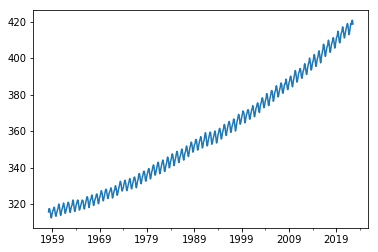

In [82]:
indexed_data['Filled'].plot()

Nous observons une augmentation systématique de la concentration de C02 couplée à une oscillation périodique à plus petite échelle. Zoomons sur une partie du graphique pour observer ces oscillations plus précisément.

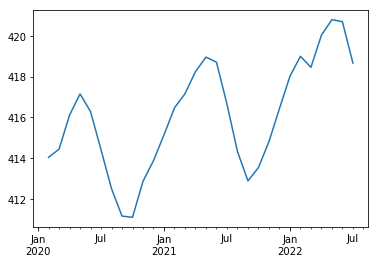

In [83]:
indexed_data["Filled"][-30:].plot()

Nous observons des variations saisonales de la concentration de C02. En ôtant ces fluctuations saisonales des données, (colonne `SAFitFilled`), nous obtenons un graphe témoignant uniquement de l'augmentation systématique de la concentration de C02 de ces 60 dernières années.

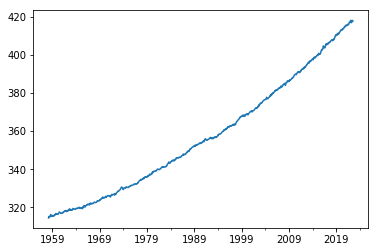

In [84]:
indexed_data['SAFitFilled'].plot()

Superposons enfin ces deux types de données sur un même graphique, globalement puis en se restreignant à une période de quelques années.

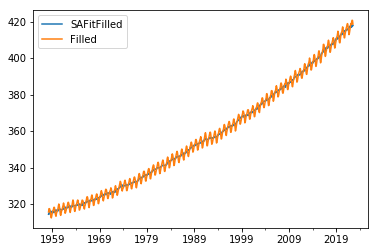

In [85]:
indexed_data.plot(y = ["SAFitFilled","Filled"])

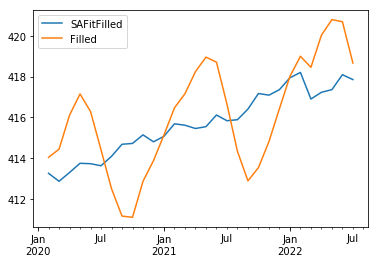

In [86]:
indexed_data[-30:].plot(y = ["SAFitFilled","Filled"])

## Fluctuations saisonales

Nous ponvons isoler les fluctuations saisonales afin de les étudier indépendemment. En voici une représentation (sur une échelle de quelques années par souci de lisibilité).

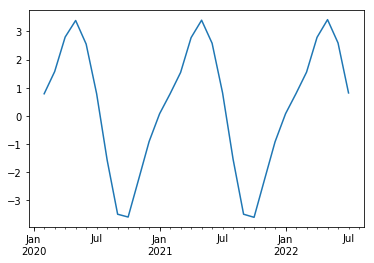

In [87]:
seasonal_fluctuations = [data.at[index,'Filled'] - data.at[index,'SAFitFilled'] for index in data.index]
indexed_data['SeasonalOnly'] = seasonal_fluctuations
indexed_data['SeasonalOnly'][-30:].plot()

Nous essayons de modéliser ces variations saisonnières par un signal triangulaire avec la fonction `curve_fit`, intialisée avec un signal triangulaire de période 12 (étant donné qu'il y a douze mois dans l'année) et d'amplitude 6 (par lecture graphique). Nous choisissons également une phase et un offset vertical correspondants à nos lectures graphiques. Enfin, nous affichons le résultat aux côtés des données initiales.

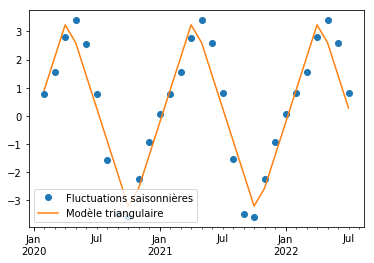

In [88]:
def signal_triangle(x, a, b, c, h):
    v = np.divide(x - h,b)
    return a * np.abs(v - np.floor(v + 0.5)) + c

x_data = np.array(data.index)
y_data = np.array(seasonal_fluctuations)

params, _ = curve_fit(signal_triangle, x_data, y_data, p0 = [12, 12, -3, 21])

fitA = params[0]
fitB = params[1]
fitC = params[2]
fitH = params[3]

indexed_data['ModelSF'] = signal_triangle(x_data, fitA, fitB, fitC, fitH)

indexed_data['SeasonalOnly'][-30:].plot(style = 'o')
indexed_data['ModelSF'][-30:].plot()
plt.legend(["Fluctuations saisonnières", "Modèle triangulaire"])

Cette modélisation a ces limites. Tout d'abord, à chaque période, la concentration en C02 augmente plus lentement qu'elle ne redescend, ce que ce signal triangulaire ne reflète pas. Nous observons de plus que l'amplitude des variations saisonnières augmente systématiquement entre 1958 et 2022, ce qui n'est pas reflété par ce modèle d'amplitude constante.

## Augmentation systématique

Nous étudions à présent l'augmentation systématique de la concentration en C02 antmosphérique. Nous tentons de modéliser les données `SAFitFilled`, c'est-à-dire les données complétées et ajustées pour omettre les fluctuations saisonnières.

Nous essayons des modèles linéaire, quadratique, et exponentiels pour ces données, donnés par les fonctions `linear`, `quadr`, et `expo`.

In [89]:
def linear(x, a, b):
    return a * x + b

def quadr(x, a, b, h):
    return a * np.square(x - h) + b

def expo(x, a, b, c, h):
    return a * np.exp(c * (x - h)) + b

Nous utilisons de nouveau la fonction `curve_fit` pour trouver quels paramètres de ces modèles correspondent au mieux à nos données.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  


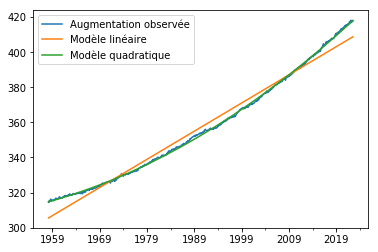

In [90]:
x_data = np.array(data.index)
y_data = np.array(data['SAFitFilled'])

params_lin, extras_lin = curve_fit(linear, x_data, y_data)
params_q, extras_q = curve_fit(quadr, x_data, y_data)
params_e, extras_e = curve_fit(expo, x_data, y_data)

fitA_lin, fitB_lin  = params_lin[0], params_lin[1]
fitA_q, fitB_q, fitH_q  = params_q[0], params_q[1], params_q[2]
fitA_e, fitB_e, fitC_e, fitH_e  = params_e[0], params_e[1], params_e[2], params_e[3]

indexed_data['ModelSA_lin'] = linear(x_data, fitA_lin, fitB_lin)
indexed_data['ModelSA_q'] = quadr(x_data, fitA_q, fitB_q, fitH_q)
indexed_data['ModelSA_e'] = expo(x_data, fitA_e, fitB_e, fitC_e, fitH_e)

indexed_data['SAFitFilled'].plot()
indexed_data['ModelSA_lin'].plot()
indexed_data['ModelSA_q'].plot()
plt.legend(["Augmentation observée", "Modèle linéaire", "Modèle quadratique"])

Nous représentons le modèle exponentiel calculé séparément par souci de lisibilité.

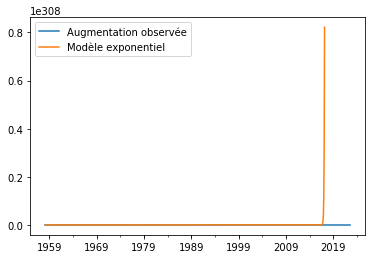

In [91]:
indexed_data['SAFitFilled'].plot()
indexed_data['ModelSA_e'].plot()
plt.legend(["Augmentation observée", "Modèle exponentiel"])

Le modèle quadratique semble correspondre assez précisément aux données, nous allons donc l'utiliser pour extrapoler l'évolution future de la concentration de C02 atmosphérique jusqu'à l'année 2050. Nous calculons le nombre de mois supplémentaires à générer par le modèle, et affichons le résultat.

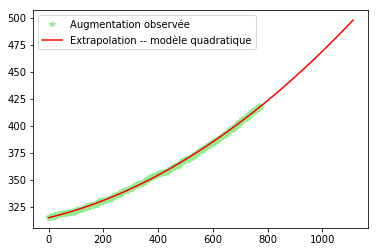

In [92]:
first_year, first_month = data.iat[0,0], data.iat[0,1]
months = range((2050 - first_year) * 12 + 12 - first_month)

extrapolation_sys_augm = quadr(months, fitA_q, fitB_q, fitH_q)
plt.plot(x_data, data['SAFitFilled'], '*', color = "lightgreen")
plt.plot(months, extrapolation_sys_augm, '-', color = "red")
plt.legend(["Augmentation observée", "Extrapolation -- modèle quadratique"])